In [1]:
from Converter import *
import numpy as np
from qiskit.tools.visualization import plot_bloch_multivector, plot_histogram
from qiskit import *
import math
from math import pi,sqrt
import cmath
from cmath import polar, acos
from qiskit import quantum_info as qi
from qiskit.circuit.library import *
from qiskit.quantum_info import Operator
from qiskit.quantum_info.synthesis.one_qubit_decompose import OneQubitEulerDecomposer

# Qiskit with Switch


In [2]:
def Qiskit_Simulator_with_switch(pm , czc, czt,im = None):
    """ 
    args:
    
    im: Input state vector
    pm: Parameters matrix
    czc: CZs control matrix
    czt: CZs target matrix
    
    Return: columns - 1 # of quantum circuits to implement a 2D cluster state 
    """
    memory = '' # Measurement result for each node stored in memory    
    rows = len(pm) # # of rows
    columns = len(pm[0]) # # of columns
    v = rows*columns # Total nodes
    m = 0
    # For layer by layer runs, columns - 1 quantum ciruits are constructed
    
    #qreg = list(range(0, columns - 1))
    creg = ClassicalRegister(rows) # Single classical register
    initialstate = [1/sqrt(2), 1/sqrt(2)]
    qreg = QuantumRegister(rows*2)
    qc = QuantumCircuit(qreg, creg)
     # Assigning quantum register and quantum circuit to the array qc and qreg respectively  
    for i in range(columns):
        
        m = i%2
        
        # State initialization of first quantum circuit
        if (i == 0):
            if (im != None):
                qc.initialize(im,list(range(0,rows)))
            #qc.initialize(im,list(range(0,rows)))
            for j in range(rows):
                #qc.initialize(im[j],j) 
                qc.h(j + rows)

        
        
        for j in range(2*rows*m-m,rows-m,(-1)**m):
            if (czc[j-rows*m][i] == 1):
                for k in range(len(czt[j-rows*m][i])):
                    qc.cz(j, j+czt[j-rows*m][i][k]) 

         # Additional code for first layers vertical CZs
       
        
        # Entanglement using CZs    
        for j in range(2*rows*m-m,rows-m,(-1)**m):
            qc.cz(j, j + (-1)**m*rows) 
        
                    
        # Applying teleportation
        for j in range(2*rows*m-m,rows-m,(-1)**m):
              
            qc.rz(pm[j-rows*m][i], j) # Rz rotation
            qc.h(j)
            qc.cx(j,j + rows*(-1)**m) 
        qc.barrier()
        
        if (i == columns-1) :
            m=(m+1)%2
            for j in range(2*rows*m-m,rows-m,(-1)**m):
                if (czc[j-rows*m][i+1] == 1):
                    for k in range(len(czt[j-rows*m][i+1])):
                        qc.cz(j, j+czt[j-rows*m][i+1][k]) 
            qc.barrier
    return qc            

# Noise mitigation ZNE

In [4]:
from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [5]:
def ZNErec(circ,n,scale_factors,backend,initial_layout = None):
    #input circ and number of qubits
    #performs the job on required backend for all scaled circuits
    folded_circuits = []
    
    for scale in scale_factors:
        folded_circuits.append(zne.scaling.fold_gates_at_random(circ, scale))
    
    #backend = sim_santiago
    shots= 8192
    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0, # Important to preserve folded gatees
        shots=shots,initial_layout = initial_layout)
    all_counts = [job.result().get_counts(k) for k in range(len(folded_circuits))]
    zero_noise_value = []
    
    
    # Performs ZNE for each basis state involved
    numbas= 2**n  #number of basis states
    
    for i in range(numbas):
        
        a = "0" + str(n) + "b"
        i=format(i,a)

        expectation_values = [counts.get(i)/shots
                      for counts in all_counts]

        zero_noise_value.append(zne.ExpFactory.extrapolate(scale_factors, expectation_values, asymptote=0.5))
    
    

    
    # Necessary corrections to add upto 1
    tot= sum(zero_noise_value)
    diff = tot - 1

    corrected_state = [a-diff*(a/tot) for a in zero_noise_value]
    
    # stores in a dict which can be plotted
    
    hist = {}
    for i in range(numbas):
        a = "0" + str(n) + "b"
        k=format(i,a)
        hist[k]=corrected_state[i]
            
    
    return hist

# IBMQ Backend and simulators 

In [6]:
#qasm simulator
simulator = qiskit.Aer.get_backend("qasm_simulator")

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# real backend
from qiskit import IBMQ
IBMQ.save_account('11b096c949c02da2b6b749443da414f34a8bb7cf7f6dc036488e57267a55f9e7ca9b5415425e719a84a07740a91ffb59b4126b22315012f8d415de3bd156a47f',overwrite = True)
provider = IBMQ.load_account()

In [9]:
#ibmq_bogota
bogota = provider.get_backend('ibmq_bogota')

In [9]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('xgate')
xm = Qiskit_Simulator_with_switch(pm , czc, czt)

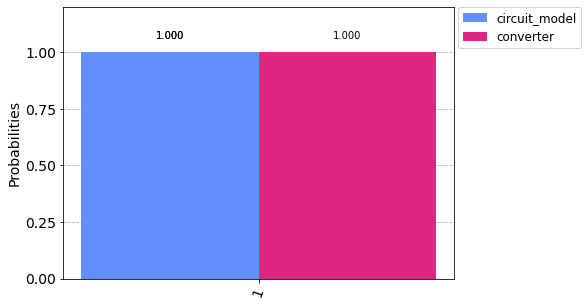

In [195]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
xc.measure_all()
job = execute(xc,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
xm.measure([0],[0])
job = execute(xm,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

In [197]:
#initial state '0'
yc = QuantumCircuit(1)
yc.y(0)
yc.qasm(filename = "ygate")

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\ny q[0];\n'

In [198]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('ygate')
ym = Qiskit_Simulator_with_switch(pm , czc, czt)

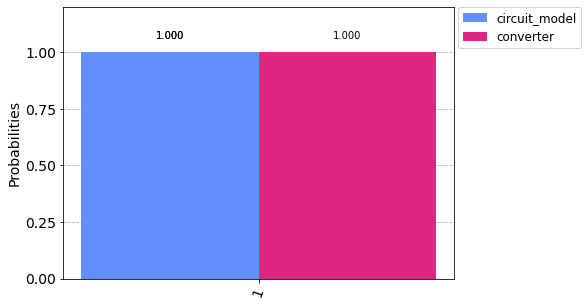

In [199]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
yc.measure_all()
job = execute(yc,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
ym.measure([0],[0])
job = execute(ym,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

In [200]:
#initial state '0'c
sc = QuantumCircuit(1)
sc.s(0)
sc.qasm(filename = "sgate")

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\ns q[0];\n'

In [201]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('sgate')
sm = Qiskit_Simulator_with_switch(pm , czc, czt)

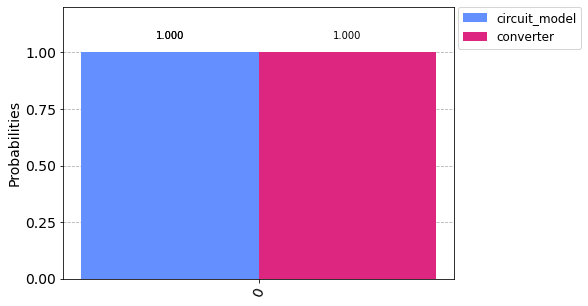

In [202]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
sc.measure_all()
job = execute(sc,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
sm.measure([0],[0])
job = execute(sm,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

In [204]:
#initial state '0'
hc = QuantumCircuit(1)
hc.h(0)
hc.qasm(filename = "hgate")

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\nh q[0];\n'

In [205]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('hgate')
hm = Qiskit_Simulator_with_switch(pm , czc, czt)

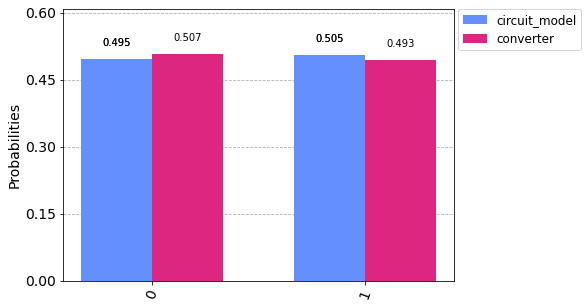

In [206]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
hc.measure_all()
job = execute(hc,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
hm.measure([0],[0])
job = execute(hm,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

## CNOT 

In [33]:
#initial state '10'
cnotc = QuantumCircuit(2)
cnotc.x(0)
cnotc.cx(0,1)
cnotc.qasm(filename = "cnot")

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nx q[0];\ncx q[0],q[1];\n'

In [34]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('cnot')
cnotm = Qiskit_Simulator_with_switch(pm , czc, czt)

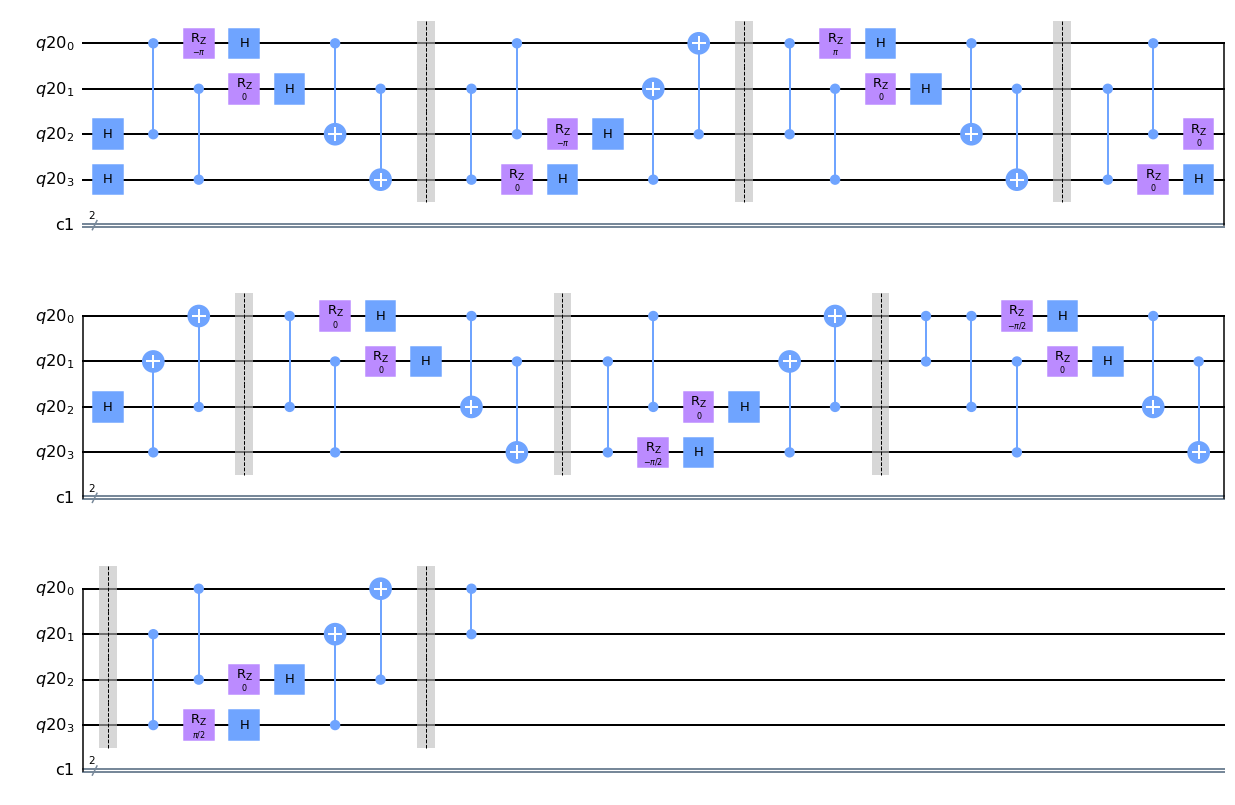

In [23]:
cnotm.draw('mpl')

### on real backend without zne and layout setting

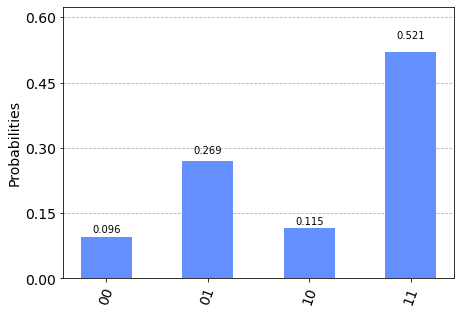

In [76]:
job = execute(cnotm,backend = backend,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram(countm)

### on real backend with layout setting but no zne

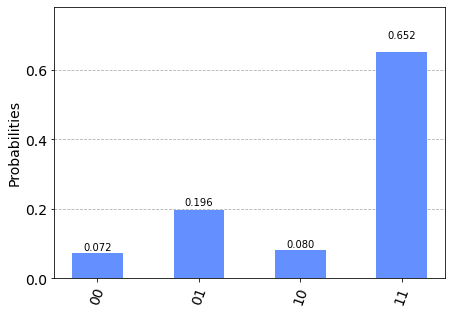

In [77]:
job = execute(cnotm,backend = backend,shots = 8192,optimization_level = 0,initial_layout = [2,4,3,1]).result()
countm = job.get_counts()
plot_histogram(countm)

### on real backend with zne and best zne settings obtained by previous experiments

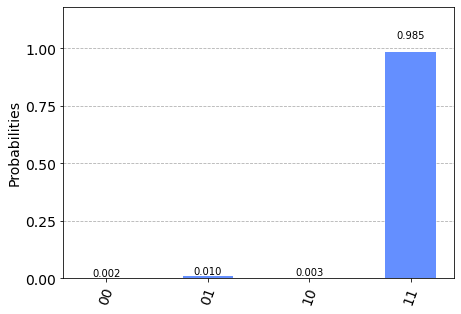

In [49]:
#best settings for cnot
backend = provider.get_backend('ibmq_bogota')
initial_layout = [2,4,3,1]
scale_factors = [1, 1.5, 2.,2.5,3.]

# output from backend
plot_histogram(ZNErec(cnotm,2,initial_layout))

### with swap gates

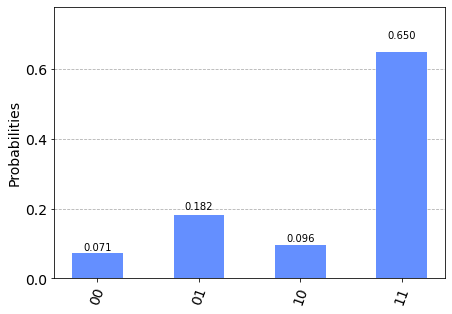

In [37]:
#good guessess for initial_layout for IBMQ_bogota
initials = [[2,4,1,3],[1,3,2,4],[3,1,4,2],[4,2,3,1]]
for initial_layout in initials:
    swap_cnot  = QuantumCircuit.from_qasm_file('swap_cnot.qasm') #a new circuit using swap gates edited via IBM Quantum_lab's composer.
    job = execute(swap_cnot,backend = bogota,shots = 8192,optimization_level = 0,initial_layout = [2,4,1,3]).result()
    countm = job.get_counts()
    plot_histogram(countm)

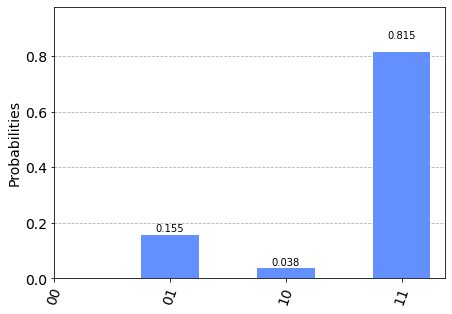

In [52]:
# Zne with swap gates method and good guess of initial layout
plot_histogram(ZNErec(swap_cnot,2,scale_factors,backend = bogota,initial_layout = [2,4,1,3]))

### Here we that there is an improvement in the results by using swap gates but not as much as using the best setting out of all the good guesses. Why is it happening the intuition says that swap gates should give more accurate results?

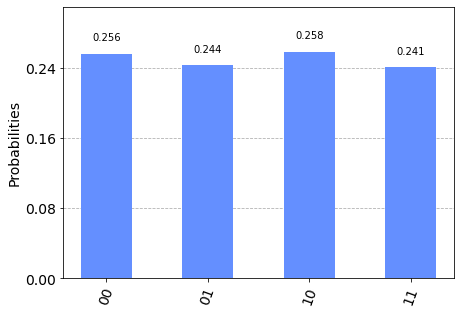

In [74]:
job = execute(swap_grv,backend = sim_bogota,shots = 8192,optimization_level = 0,initial_layout = [1,3,2,4]).result()
countm = job.get_counts()
plot_histogram(countm)

In [32]:
#scale_factors = [1, 1.5, 2.,2.5,3.]
#plot_histogram(ZNErec(swap_grv,2,scale_factors,bogota,initial_layout=[[2,4,1,3]]))
job = bogota.jobs(limit = 1)[0]
count = job.result().get_counts()
plot_histogram(count)

KeyboardInterrupt: 

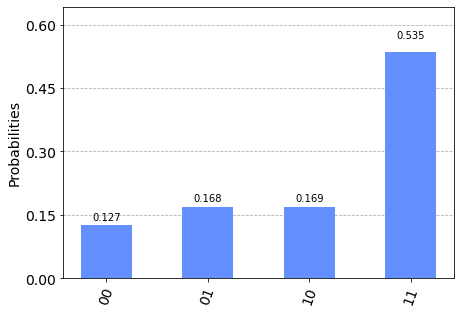

In [16]:
grvm.measure([0,1],[0,1])
job = execute(grvm,backend = sim_bogota,shots = 8192,optimization_level = 0,initial_layout = [1,3,2,4]).result()
countm = job.get_counts()
plot_histogram(countm)

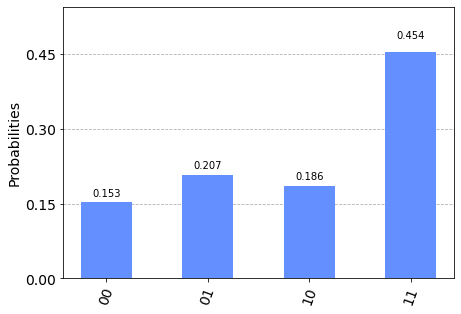

In [20]:
initial_layout = [1,3,2,4]
scale_factors = [1, 1.5, 2.,2.5,3.]
plot_histogram(ZNErec(grvm,2,scale_factors,sim_bogota,initial_layout))

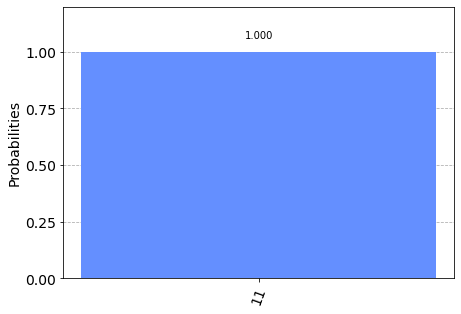

In [26]:
job = execute(grvm,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
plot_histogram(countc)

### Testing over

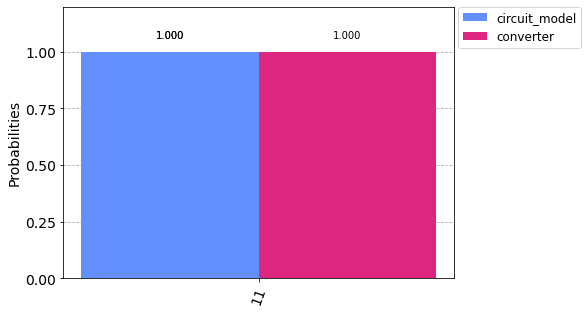

In [52]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
grvc.measure_all()
job = execute(grvc,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
grvm.measure([0,1],[0,1])
job = execute(grvm,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

### on real backend without zne and layout setting

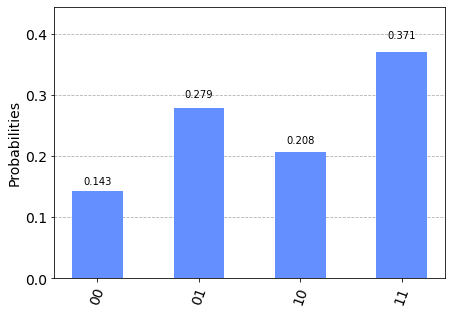

In [81]:
job = execute(grvm,backend = backend,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram(countm)

### on real backend with layout setting but no zne

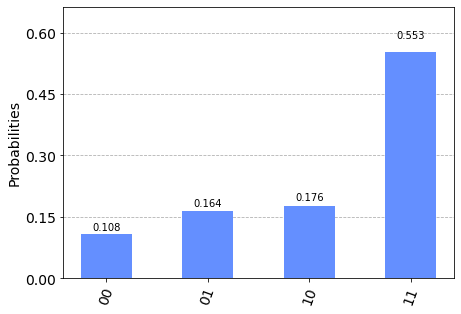

In [82]:
job = execute(grvm,backend = backend,shots = 8192,optimization_level = 0,initial_layout = [2,1,3,4]).result()
countm = job.get_counts()
plot_histogram(countm)

### with zne and best settings

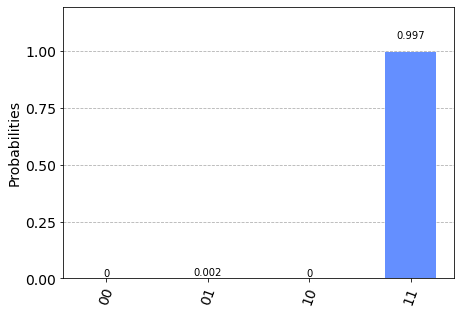

In [58]:
#best settings for grover(2 qubit)
initial_layout = [2,1,3,4]
# output from backend
plot_histogram(ZNErec(grvm,2,scale_factors,initial_layout))

In [173]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('bvc')
bvcm = Qiskit_Simulator_with_switch(pm , czc, czt)

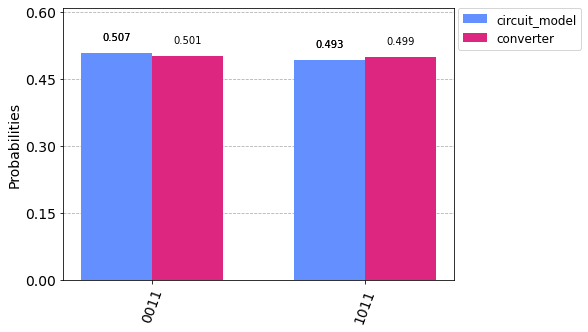

In [174]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
bvc.measure_all()
job = execute(bvc,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
bvcm.measure([0,1,2,3],[0,1,2,3])
job = execute(bvcm,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

### without zne

In [188]:
#backend guadalupe
from qiskit.test.mock import FakeToronto
sim_toro = AerSimulator.from_backend(FakeToronto())
backend = sim_toro

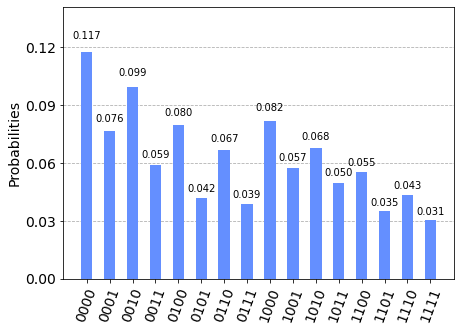

In [189]:
job = execute(bvcm,backend = backend,shots = 8192,optimization_level = 0).result()
count = job.get_counts()
plot_histogram(count)

### with zne and trying to find best settings 

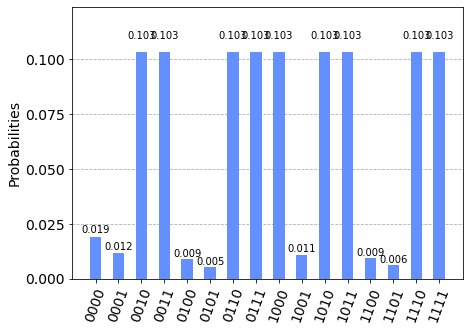

(7, 10, 12, 15, 13, 11, 14, 16)


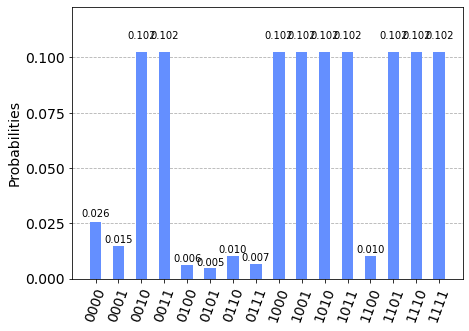

(7, 10, 12, 15, 13, 11, 16, 14)


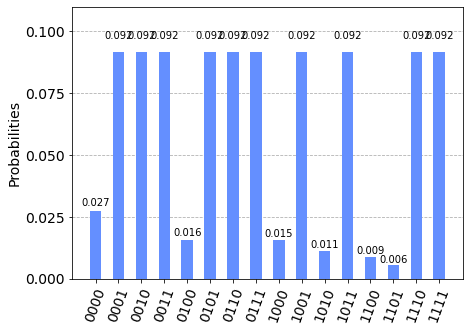

(7, 10, 12, 15, 13, 14, 11, 16)


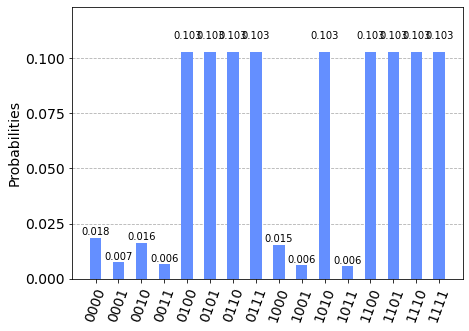

(7, 10, 12, 15, 13, 14, 16, 11)


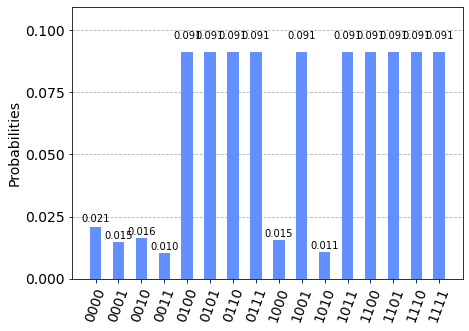

(7, 10, 12, 15, 13, 16, 11, 14)


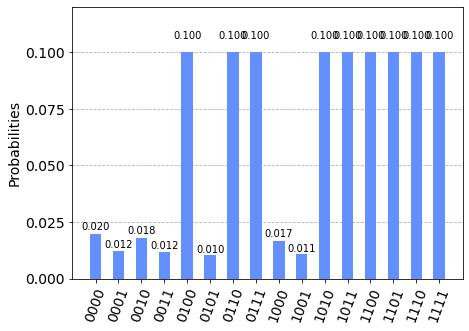

(7, 10, 12, 15, 13, 16, 14, 11)


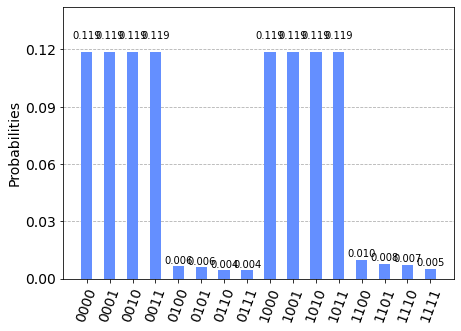

(7, 10, 12, 15, 11, 13, 14, 16)


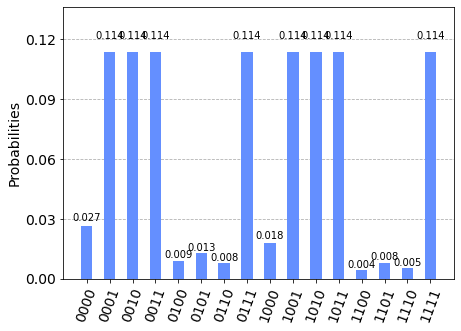

(7, 10, 12, 15, 11, 13, 16, 14)


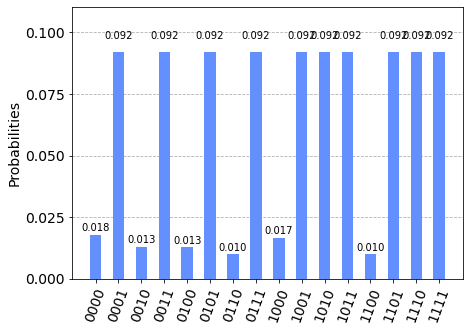

(7, 10, 12, 15, 11, 14, 13, 16)


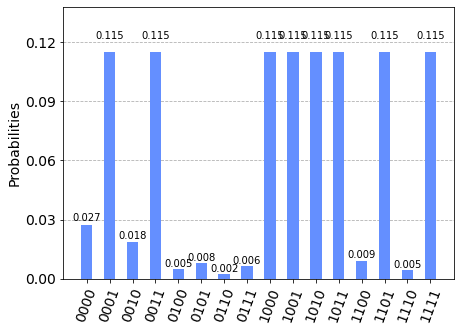

(7, 10, 12, 15, 11, 14, 16, 13)


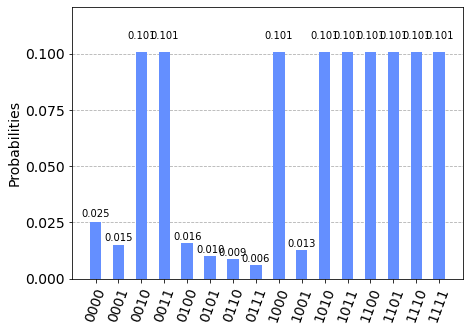

(7, 10, 12, 15, 11, 16, 13, 14)


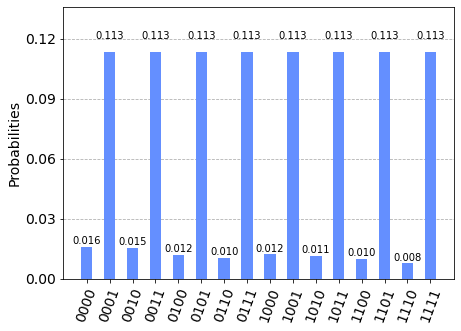

(7, 10, 12, 15, 11, 16, 14, 13)


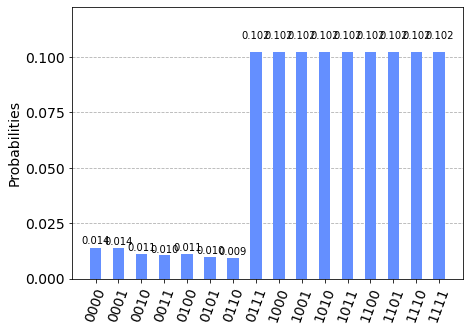

(7, 10, 12, 15, 14, 13, 11, 16)


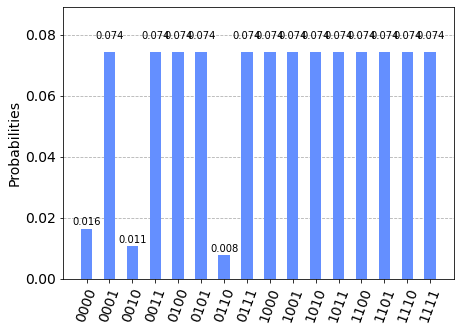

(7, 10, 12, 15, 14, 13, 16, 11)


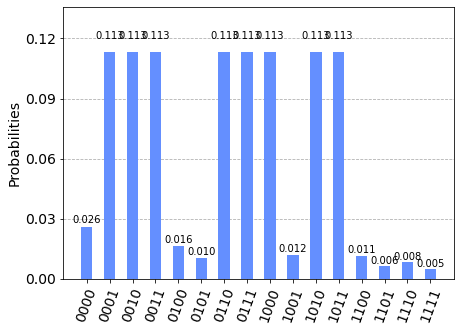

(7, 10, 12, 15, 14, 11, 13, 16)


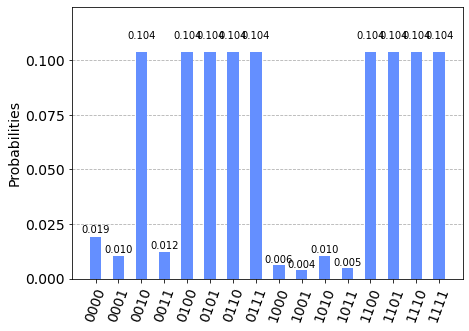

(7, 10, 12, 15, 14, 11, 16, 13)


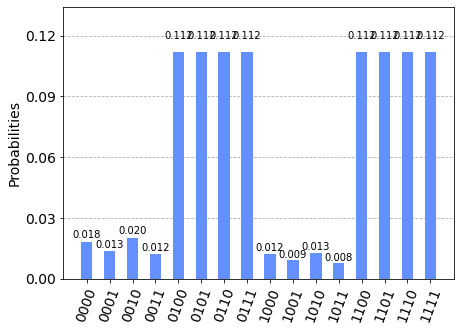

(7, 10, 12, 15, 14, 16, 13, 11)


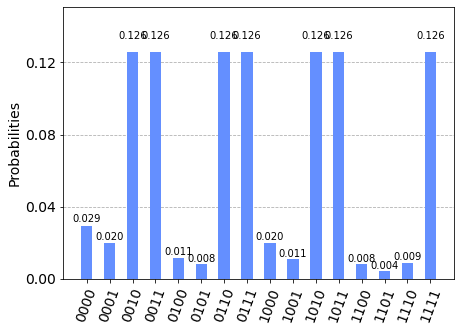

(7, 10, 12, 15, 14, 16, 11, 13)


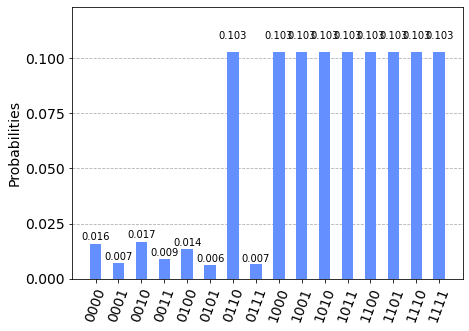

(7, 10, 12, 15, 16, 13, 11, 14)


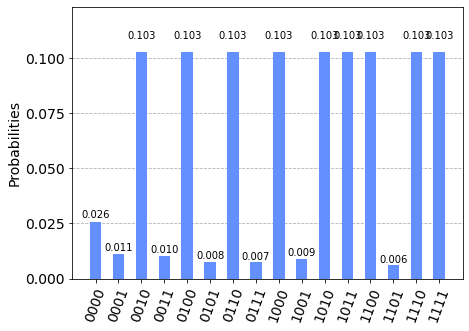

(7, 10, 12, 15, 16, 13, 14, 11)


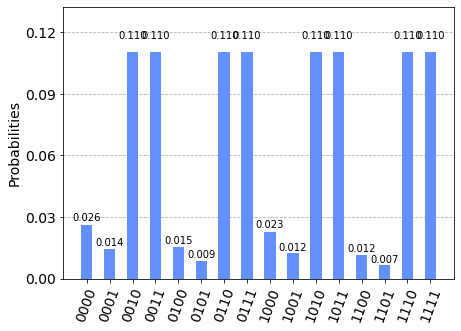

(7, 10, 12, 15, 16, 11, 13, 14)


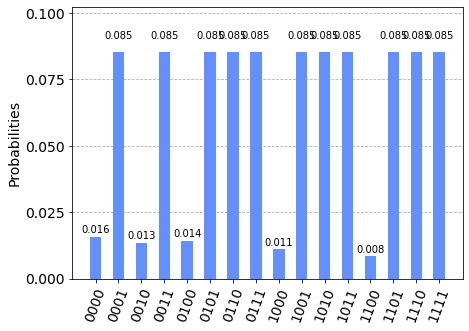

(7, 10, 12, 15, 16, 11, 14, 13)


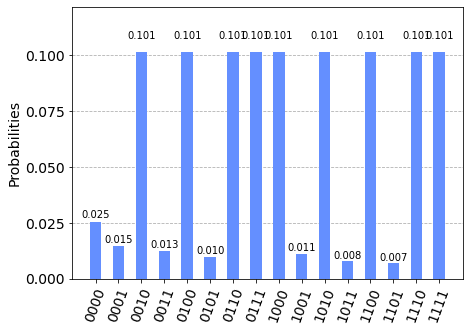

(7, 10, 12, 15, 16, 14, 13, 11)


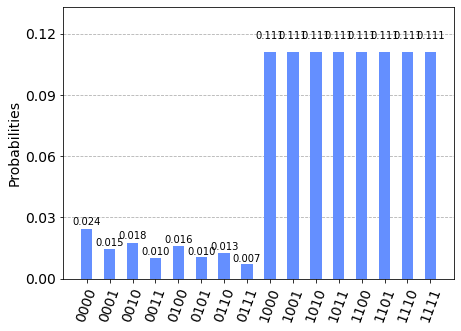

(7, 10, 12, 15, 16, 14, 11, 13)


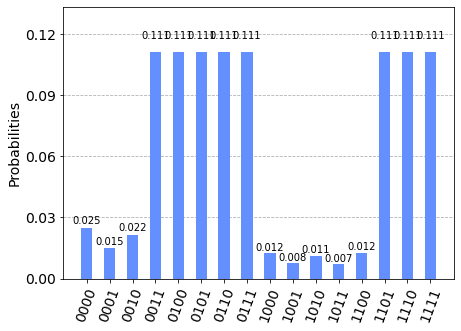

(7, 10, 12, 13, 15, 11, 14, 16)


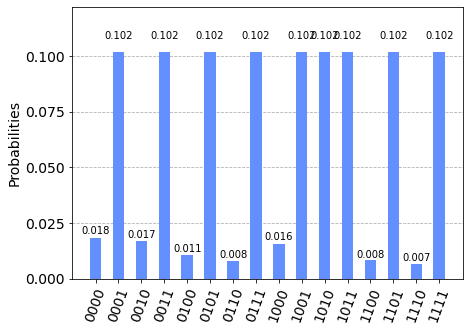

(7, 10, 12, 13, 15, 11, 16, 14)


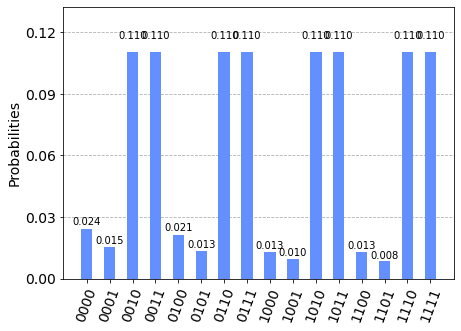

(7, 10, 12, 13, 15, 14, 11, 16)


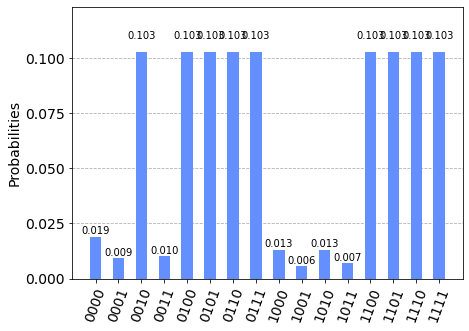

(7, 10, 12, 13, 15, 14, 16, 11)


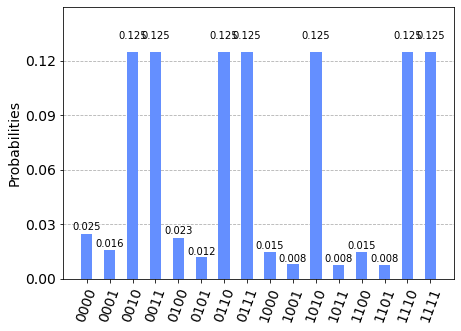

(7, 10, 12, 13, 15, 16, 11, 14)


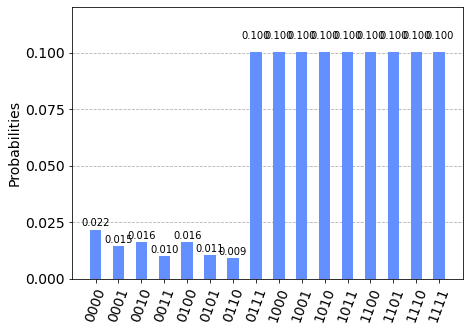

(7, 10, 12, 13, 15, 16, 14, 11)


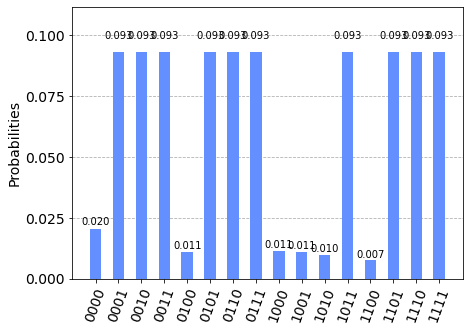

(7, 10, 12, 13, 11, 15, 14, 16)


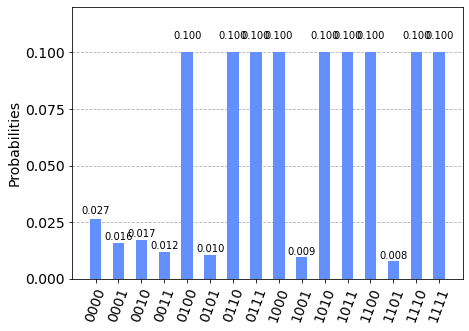

(7, 10, 12, 13, 11, 15, 16, 14)


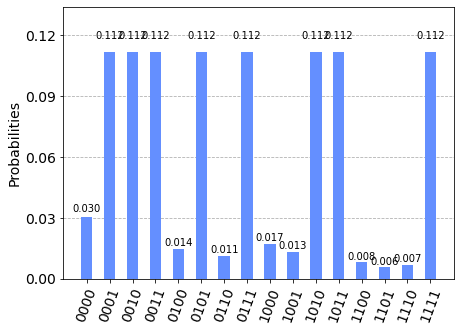

(7, 10, 12, 13, 11, 14, 15, 16)


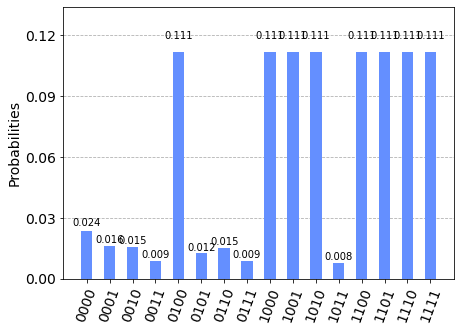

(7, 10, 12, 13, 11, 14, 16, 15)


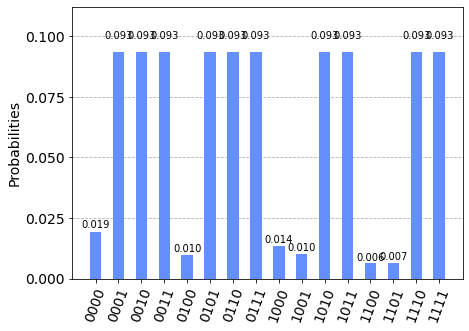

(7, 10, 12, 13, 11, 16, 15, 14)


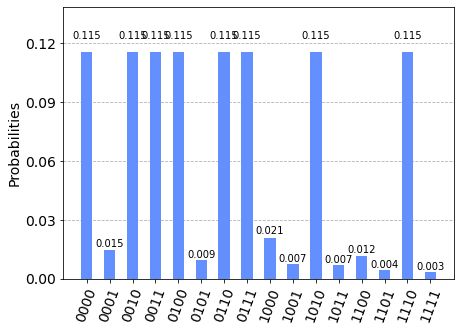

(7, 10, 12, 13, 11, 16, 14, 15)


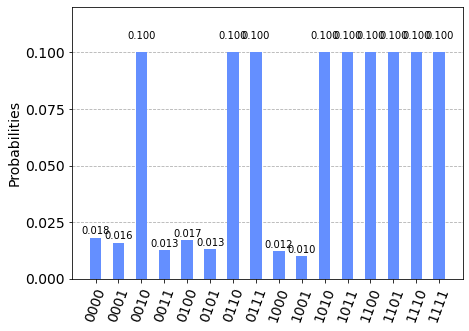

(7, 10, 12, 13, 14, 15, 11, 16)


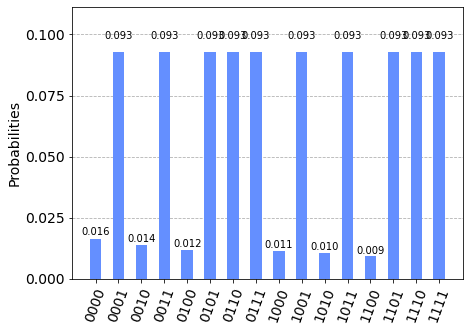

(7, 10, 12, 13, 14, 15, 16, 11)


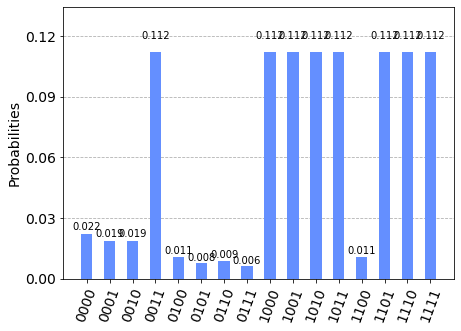

(7, 10, 12, 13, 14, 11, 15, 16)


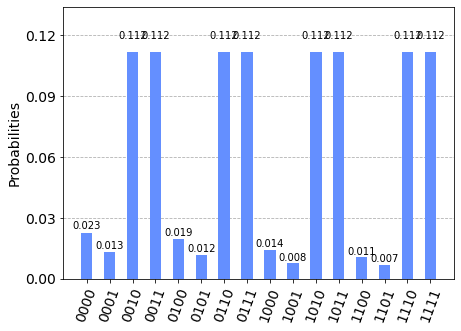

(7, 10, 12, 13, 14, 11, 16, 15)


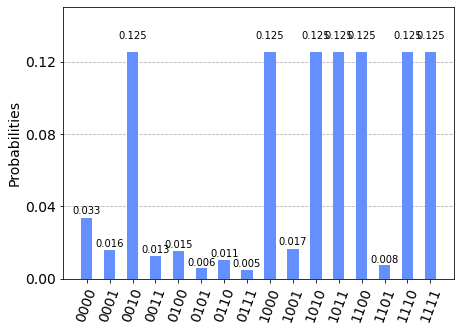

(7, 10, 12, 13, 14, 16, 15, 11)


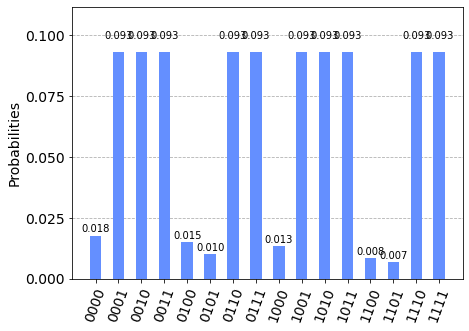

(7, 10, 12, 13, 14, 16, 11, 15)


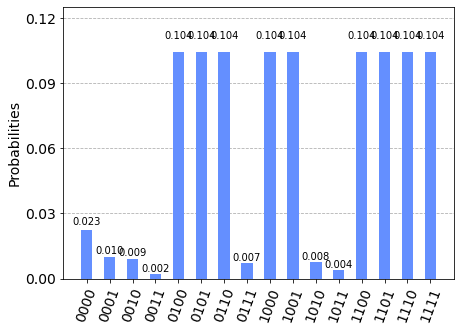

(7, 10, 12, 13, 16, 15, 11, 14)


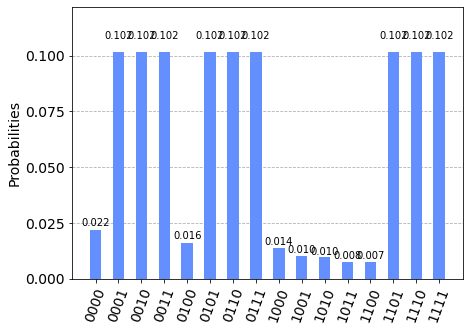

(7, 10, 12, 13, 16, 15, 14, 11)


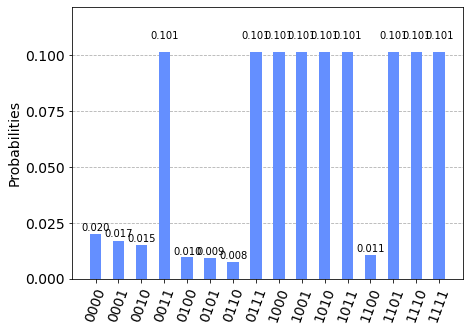

(7, 10, 12, 13, 16, 11, 15, 14)


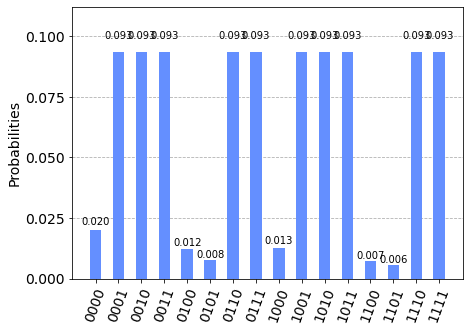

(7, 10, 12, 13, 16, 11, 14, 15)


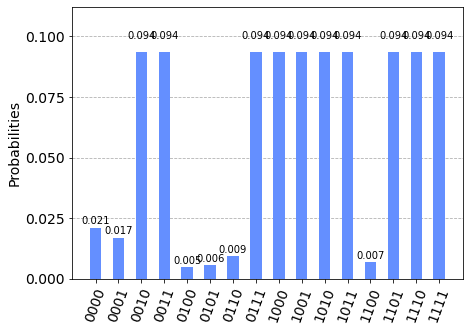

(7, 10, 12, 13, 16, 14, 15, 11)


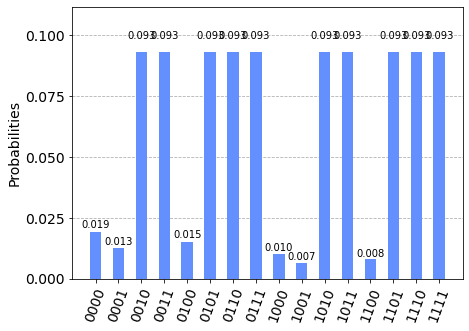

(7, 10, 12, 13, 16, 14, 11, 15)


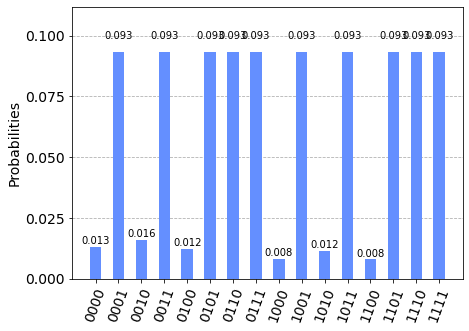

(7, 10, 12, 11, 15, 13, 14, 16)


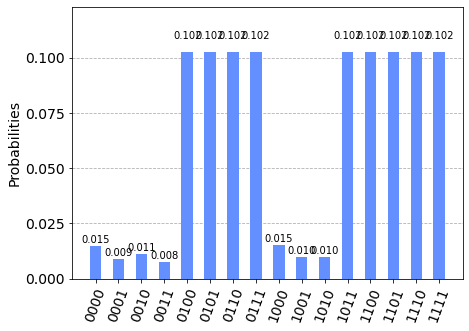

(7, 10, 12, 11, 15, 13, 16, 14)


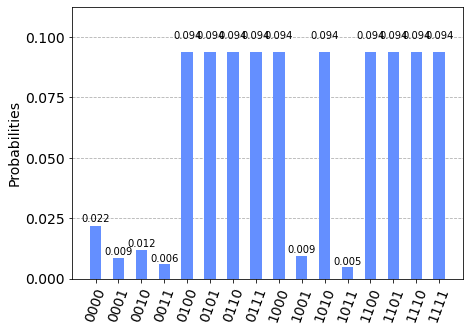

(7, 10, 12, 11, 15, 14, 13, 16)


KeyboardInterrupt: 

In [175]:
from itertools import permutations
initials = list(permutations([7,10,12,15,13,11,14,16]))
for initial_layout in initials:
    display(plot_histogram(ZNErec(bvcm,4,scale_factors,initial_layout = initial_layout)))
    print(initial_layout)

In [151]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('da')
dam = Qiskit_Simulator_with_switch(pm , czc, czt)

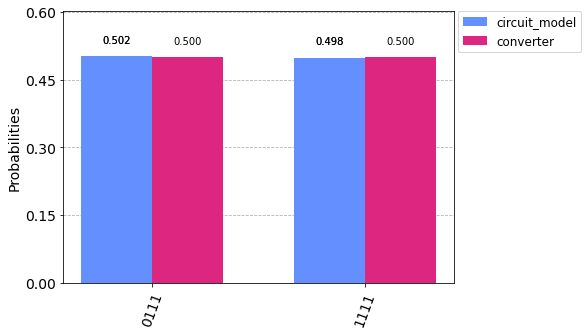

In [152]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
da.measure_all()
job = execute(da,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
dam.measure([0,1,2,3],[0,1,2,3])
job = execute(dam,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

### without zne 

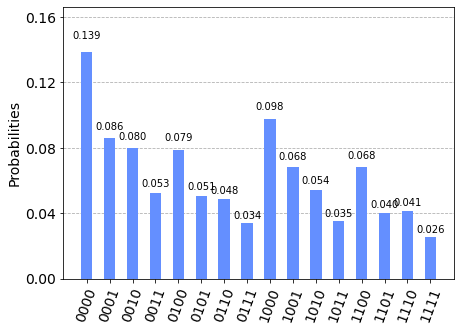

In [190]:
job = execute(dam,backend = backend,shots = 8192,optimization_level = 0).result()
count = job.get_counts()
plot_histogram(count)

### with zne

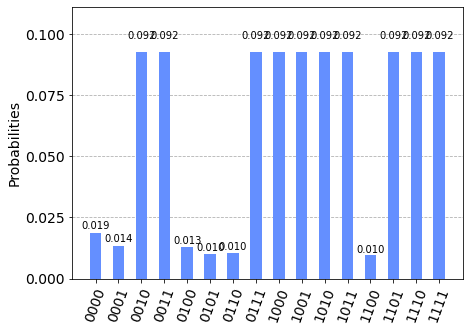

In [176]:
plot_histogram(ZNErec(dam,4,scale_factors,initial_layout = initial_layout))

In [182]:
qft3 = QuantumCircuit(3)
qft3.h([0,1,2])
qft3.h(2)
qft3.cp(pi/2,1,2)
qft3.cp(pi/4,0,2)
qft3.h(1)
qft3.cp(pi/2,0,1)
qft3.h(0)
qft3.swap(0,2)
qft3.qasm(filename = 'qft3')

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[0];\nh q[1];\nh q[2];\nh q[2];\ncp(pi/2) q[1],q[2];\ncp(pi/4) q[0],q[2];\nh q[1];\ncp(pi/2) q[0],q[1];\nh q[0];\nswap q[0],q[2];\n'

In [183]:
# using converter to obtain equivalent mbqc circuit
pm, czc, czt = Converter().to_mbqc('qft3')
qft3m = Qiskit_Simulator_with_switch(pm , czc, czt)

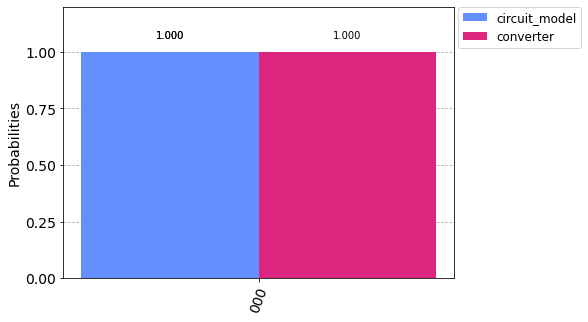

In [184]:
# comparing the output of circuit model and mbqc model(from converter) using qasm simulator
qft3.measure_all()
job = execute(qft3,backend = simulator,shots = 8192,optimization_level = 0).result()
countc = job.get_counts()
qft3m.measure([0,1,2],[0,1,2])
job = execute(qft3m,backend = simulator,shots = 8192,optimization_level = 0).result()
countm = job.get_counts()
plot_histogram([countc,countm],legend = ['circuit_model','converter'])

### without zne

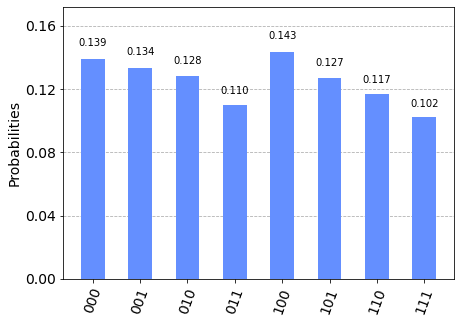

In [191]:
backend = sim_casa
job = execute(qft3m,backend = backend,shots = 8192,optimization_level = 0).result()
count = job.get_counts()
plot_histogram(count)

### with zne

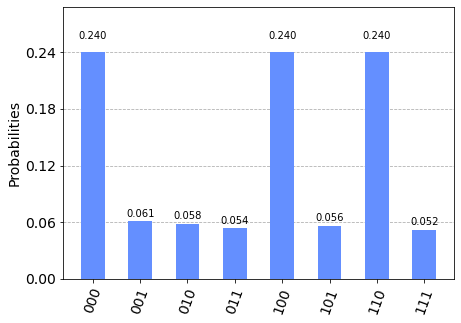

In [186]:
backend = sim_casa
#from itertools import permutations
#initials = list(permutations([0,1,2,3,4,5]))
#for initial_layout in initials:
display(plot_histogram(ZNErec(qft3m,3,scale_factors)))


In [6]:
from quantastica.qiskit_forest import ForestBackend

In [18]:
reg_sim = ForestBackend.get_backend("qasm_simulator")

### X-gate

In [21]:
xm.measure([0],[0])

In [25]:
job = execute(xm,backend = reg_sim).result()
countm = job.get_counts()
plot_histogram(countm)

ConnectError: [Errno 111] Connection refused